In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import dipy.reconst.sfm as sfm
import dipy.reconst.csdeconv as csd
import dipy.reconst.dti as dti
import dipy.core.gradients as grad
import dipy.data as dpd

In [3]:
import utils
from model import Model, BiExponentialIsotropicModel, my_responses

In [4]:
len(my_responses)

45

In [5]:
data = utils.read_data()

In [6]:
all_bvals = data['seen']['bvals']
unique_bvals = np.unique(all_bvals)
b0s_idx = np.where(all_bvals==0)

In [7]:
unique_bvals

array([     0.        ,     51.01021361,     99.70178114,    103.05093658,
          150.71199475,    199.40356228,    250.41377589,    299.10534342,
          302.2827473 ,    399.32237925,    489.49194876,    502.37331583,
          599.06944465,    650.50903716,   1004.74663166,   1308.05988833,
         1604.84658568,   1709.88220696,   1951.09773259,   2061.0187316 ,
         2086.78146575,   2550.51068036,   3040.00262912,   3175.49552721,
         3188.13835045,   3541.89885728,   4457.90718243,   6492.20900455,
         6732.66118991,  14564.53237001,  21495.66203036,  30228.2747302 ,
        38060.1459103 ,  45892.01709039])

In [8]:
vox_idx = 0

In [9]:
train_data = []
train_bvals = []
train_bvecs = []
train_delta = []
train_Delta = []
train_te = []
train_g = []

for this_bv in unique_bvals[1:][::2]:
    idx = np.where(all_bvals == this_bv)
    train_data.append(data['seen']['signal'][:, vox_idx][idx])
    train_bvals.append(data['seen']['bvals'][idx])
    train_bvecs.append(data['seen']['bvecs'][idx])
    train_delta.append(data['seen']['delta'][idx])
    train_Delta.append(data['seen']['Delta'][idx])
    train_te.append(data['seen']['TE'][idx])
    train_g.append(data['seen']['g'][idx])

train_data = np.hstack(train_data)
train_bvals = np.hstack(train_bvals)
train_bvecs = np.vstack(train_bvecs)
train_delta = np.hstack(train_delta)
train_Delta = np.hstack(train_Delta)
train_te = np.hstack(train_te)
train_g = np.hstack(train_g)
    
train_data = np.hstack([train_data, data['seen']['signal'][:, vox_idx][b0s_idx[::2]]])
train_bvals = np.hstack([train_bvals, data['seen']['bvals'][b0s_idx[::2]]])
train_bvecs = np.vstack([train_bvecs, data['seen']['bvecs'][b0s_idx[::2]]])
train_delta = np.hstack([train_delta, data['seen']['delta'][b0s_idx[::2]]])
train_Delta = np.hstack([train_Delta, data['seen']['Delta'][b0s_idx[::2]]])
train_te = np.hstack([train_te, data['seen']['TE'][b0s_idx[::2]]])
train_g = np.hstack([train_g, data['seen']['g'][b0s_idx[::2]]])
    
    
test_data = []
test_bvals = []
test_bvecs = []
test_delta = []
test_Delta = []
test_te = []
test_g = []

    
for this_bv in unique_bvals[1:][1::2]:
    idx = np.where(all_bvals == this_bv)
    test_data.append(data['seen']['signal'][:, vox_idx][idx])
    test_bvals.append(data['seen']['bvals'][idx])
    test_bvecs.append(data['seen']['bvecs'][idx])
    test_delta.append(data['seen']['delta'][idx])
    test_Delta.append(data['seen']['Delta'][idx])
    test_te.append(data['seen']['TE'][idx])
    test_g.append(data['seen']['g'][idx])

test_data = np.hstack(test_data)
test_bvals = np.hstack(test_bvals)
test_bvecs = np.vstack(test_bvecs)
test_delta = np.hstack(test_delta)
test_Delta = np.hstack(test_Delta)
test_te = np.hstack(test_te)
test_g = np.hstack(test_g)

test_data = np.hstack([test_data, data['seen']['signal'][:, vox_idx][b0s_idx[1::2]]])
test_bvals = np.hstack([test_bvals, data['seen']['bvals'][b0s_idx[1::2]]])
test_bvecs = np.vstack([test_bvecs, data['seen']['bvecs'][b0s_idx[1::2]]])
test_delta = np.hstack([test_delta, data['seen']['delta'][b0s_idx[1::2]]])
test_Delta = np.hstack([test_Delta, data['seen']['Delta'][b0s_idx[1::2]]])
test_te = np.hstack([test_te, data['seen']['TE'][b0s_idx[1::2]]])
test_g = np.hstack([test_g, data['seen']['g'][b0s_idx[1::2]]])

In [10]:
train_bvecs.shape

(1871, 3)

In [11]:
train_gtab = grad.gradient_table(train_bvals, train_bvecs, big_delta=train_Delta, small_delta=train_delta)
test_gtab = grad.gradient_table(test_bvals, test_bvecs, big_delta=test_Delta, small_delta=test_delta)

In [12]:
train_s0 = train_data[train_gtab.b0s_mask]

In [13]:
sphere = dpd.get_sphere('symmetric724')
#sphere = sphere.subdivide(1)

In [14]:
import sklearn.linear_model as lm
model1 = Model(train_gtab, isotropic=BiExponentialIsotropicModel,sphere=sphere,
               solver=lm.ElasticNet(l1_ratio=0.1, alpha=1e-5, positive=True, warm_start=True,# max_iter=25000, 
                                                                               fit_intercept=True, normalize=True))

model2 = Model(test_gtab, isotropic=BiExponentialIsotropicModel,sphere=sphere,
               solver=lm.ElasticNet(l1_ratio=0.1, alpha=1e-5, positive=True, warm_start=True,#max_iter=25000, 
                                                                fit_intercept=True, normalize=True))

In [15]:
fit1 = model1.fit(train_data, train_te, train_g)
fit2 = model2.fit(test_data, test_te, test_g)

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:490: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [16]:
predict1= fit1.predict(test_gtab, test_te)
predict2= fit2.predict(train_gtab, train_te)

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


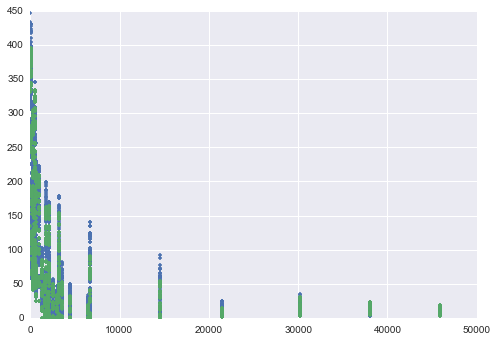

In [17]:
plt.plot(test_gtab.bvals, test_data, '.')
plt.plot(test_gtab.bvals, predict1, '.')

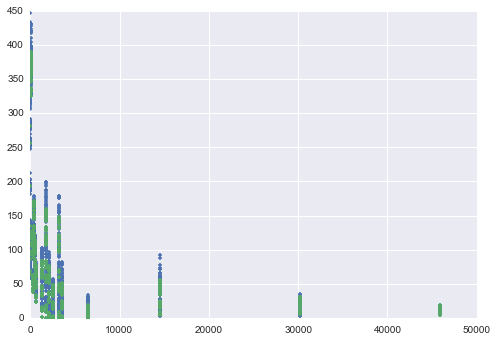

In [18]:
plt.plot(train_gtab.bvals, train_data, '.')
plt.plot(train_gtab.bvals, predict2, '.')

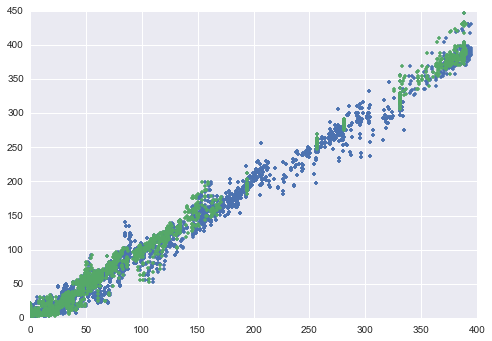

In [19]:
plt.plot(predict1, test_data, '.')
plt.plot(predict2, train_data, '.')

In [20]:
utils.LSE(predict1, test_data), utils.LSE(predict2, train_data) 

(2.4367823873001377, 1.7079084753619351)

In [25]:
np.sum(fit1.beta>0)

50